# LOGISTIC REGRESSION

**Pre-processing Steps:**
-  **Feature Engineering**: Extract and create meaningful features from existing data.
-  **Feature Scaling**: Standardise or normalise features to ensure consistent scaling.
-  **Transform Categorical Variables**: Use one-hot encoding to convert categorical data into numerical format.
-  **Fix Class Imbalances**: Apply techniques like oversampling, undersampling, or use class weights.

**Model Building Steps:**
-  **Regularisation**: Use L1 or L2 regularisation to prevent overfitting.
-  **Build, Train, and Test Model**: Develop the logistic regression model and split data into training and testing sets.
-  **Evaluate Model Performance**: Use metrics like accuracy, precision, recall, F1-score, and AUC-ROC.
-  **Cross-Validation**: Perform cross-validation to ensure model generalisation.

## DOCUMENT PREAMBLE

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Configure tqdm and matplotlib
tqdm.pandas()
plt.style.use("classic")
#plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.family"] = "serif"

In [2]:
# Load data from parquet files in the 'data_processed' folder
def load_data(version, data_type):
    if data_type not in ["train", "validation"]:
        raise ValueError("data_type must be either 'train' or 'validation'")

    # Define file paths with the new naming convention
    base_path = f"./data_processed/{version}_{data_type}_"
    behaviors_file = f"{base_path}behaviors_df_expanded.parquet"
    history_file = f"{base_path}history_df_expanded.parquet"
    articles_file = f"{base_path}articles_df_expanded.parquet"
    users_file = f"{base_path}users_df_expanded.parquet"

    # Read parquet files into DataFrames
    behaviors_df = pd.read_parquet(behaviors_file)
    history_df = pd.read_parquet(history_file)
    articles_df = pd.read_parquet(articles_file)
    users_df = pd.read_parquet(users_file)

    # Print DataFrame info
    for name, df in zip(
        ["behaviors_df", "history_df", "articles_df", "users_df"],
        [behaviors_df, history_df, articles_df, users_df],
    ):
        print(f"--- '{name}' ---\n")
        print(df.info(), "\n")

    return behaviors_df, history_df, articles_df, users_df

# Set parameters and load data
version = "demo"
data_type = "train"
behaviors_df, history_df, articles_df, users_df = load_data(version, data_type)

--- 'behaviors_df' ---

<class 'pandas.core.frame.DataFrame'>
Index: 242327 entries, 0 to 21823
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   impression_id                      242327 non-null  uint32        
 1   impression_article_id              242327 non-null  float64       
 2   impression_time                    242327 non-null  datetime64[us]
 3   impression_read_time               242327 non-null  float32       
 4   impression_scroll_percentage       242327 non-null  float32       
 5   impression_device_type             242327 non-null  int8          
 6   impression_article_id_inview       242327 non-null  int64         
 7   impression_article_id_clicked      242327 non-null  int64         
 8   user_id                            242327 non-null  uint32        
 9   user_is_sso                        242327 non-null  bool          
 10  us

In [3]:
# Initial number of rows in behaviors_df
initial_row_count = behaviors_df.shape[0]

# Merge behaviors_df with articles_df using inner join
df_articles_merged = pd.merge(behaviors_df, articles_df, left_on='impression_article_id_inview', right_on='article_id', how='inner')
after_articles_merge_count = df_articles_merged.shape[0]
dropped_after_articles_merge = initial_row_count - after_articles_merge_count
dropped_articles_percentage = (dropped_after_articles_merge / initial_row_count) * 100
print(f"Rows dropped after merging behaviors_df with articles_df using inner join: {dropped_after_articles_merge} ({dropped_articles_percentage:.2f}%)")

# Merge the result with users_df using inner join
df_final = pd.merge(df_articles_merged, users_df, on='user_id', how='inner')
final_row_count = df_final.shape[0]
dropped_after_users_merge = after_articles_merge_count - final_row_count
dropped_users_percentage = (dropped_after_users_merge / after_articles_merge_count) * 100
print(f"Rows dropped after merging with users_df using inner join: {dropped_after_users_merge} ({dropped_users_percentage:.2f}%)")

# Total dropped rows and percentage
total_dropped_rows = initial_row_count - final_row_count
total_dropped_percentage = (total_dropped_rows / initial_row_count) * 100
print(f"Total rows dropped after all merges: {total_dropped_rows} ({total_dropped_percentage:.2f}%)")

Rows dropped after merging behaviors_df with articles_df using inner join: 0 (0.00%)
Rows dropped after merging with users_df using inner join: 0 (0.00%)
Total rows dropped after all merges: 0 (0.00%)


In [4]:
# Print all available features and their data types
print("Available features:")
list(df_final.columns)

Available features:


['impression_id',
 'impression_article_id',
 'impression_time',
 'impression_read_time',
 'impression_scroll_percentage',
 'impression_device_type',
 'impression_article_id_inview',
 'impression_article_id_clicked',
 'user_id',
 'user_is_sso',
 'user_is_subscriber',
 'impression_session_id',
 'impression_next_read_time',
 'impression_next_scroll_percentage',
 'impression_day_of_week',
 'impression_hour',
 'impression_day_of_week_sin',
 'impression_day_of_week_cos',
 'impression_hour_sin',
 'impression_hour_cos',
 'impression_is_frontpage',
 'session_avg_read_time',
 'session_avg_scroll_percentage',
 'target',
 'article_id',
 'article_title',
 'article_subtitle',
 'article_is_premium',
 'article_body',
 'article_published_time',
 'article_type',
 'article_url',
 'article_ner_clusters',
 'article_entity_groups',
 'article_topics',
 'article_category',
 'article_subcategory',
 'article_category_str',
 'article_sentiment_score',
 'article_sentiment_label',
 'article_published_year',
 'arti

In [14]:
# 1. Months Difference Between Impression and Article Publication
df_final['months_since_publication'] = ((df_final['impression_time'].dt.year - df_final['article_published_time'].dt.year) * 12 +
                                         (df_final['impression_time'].dt.month - df_final['article_published_time'].dt.month))

# 2. Difference in Sentiment Scores
df_final['sentiment_score_difference'] = df_final['article_sentiment_score'] - df_final['user_avg_sentiment_score']

# 3. Clickthrough Rate Proxy
df_final['article_clickthrough_rate'] = df_final['article_total_pageviews_log'] - df_final['article_total_inviews_log']

# 4. Matching Topics
df_final['matching_topics_count'] = df_final.apply(
    lambda row: sum(topic in row['user_top_topics'] for topic in row['article_topics']), axis=1)

# 5. Matching NER Clusters
df_final['matching_ner_clusters_count'] = df_final.apply(
    lambda row: sum(cluster in row['user_top_ner_clusters'] for cluster in row['article_ner_clusters']), axis=1)

# 6. Matching Subcategories
df_final['matching_subcategories_count'] = df_final.apply(
    lambda row: sum(subcat in row['user_top_subcategories'] for subcat in row['article_subcategory']), axis=1)

# 7. Matching Categories
df_final['matching_categories_count'] = df_final.apply(
    lambda row: sum(cat in row['user_top_categories'] for cat in [row['article_category']]), axis=1)

# 8. Average Article Read Time and User Read Time Difference
df_final['article_avg_read_time'] = df_final['article_total_read_time_log'] / df_final['article_total_inviews_log']
df_final['read_time_difference'] = df_final['article_avg_read_time'] - df_final['user_avg_read_time']

# 9. Session and Article Average Read Time Comparison
df_final['session_article_read_time_difference'] = df_final['session_avg_read_time'] - df_final['article_avg_read_time']

# 10. User Engagement Score
df_final['user_engagement_score'] = (df_final['impression_read_time'] * df_final['impression_scroll_percentage'] *
                                      (df_final['impression_article_id_clicked'] + 1))

impression_id                                        152513
impression_article_id                             9778745.0
impression_time                         2023-05-24 07:31:26
impression_read_time                                   30.0
impression_scroll_percentage                          100.0
                                               ...         
matching_categories_count                                 0
article_avg_read_time                              1.191621
read_time_difference                             -58.574508
session_article_read_time_difference              28.808379
user_engagement_score                         29335986000.0
Name: 0, Length: 76, dtype: object


In [30]:
print(df_final.sample(5).iloc[:, -11:].transpose())

                                            223147        148048  \
months_since_publication              0.000000e+00  0.000000e+00   
sentiment_score_difference           -1.295956e-01 -2.243403e-01   
article_clickthrough_rate            -1.566407e+00 -1.717757e+00   
matching_topics_count                 0.000000e+00  2.000000e+00   
matching_ner_clusters_count           0.000000e+00  1.000000e+00   
matching_subcategories_count          0.000000e+00  0.000000e+00   
matching_categories_count             0.000000e+00  0.000000e+00   
article_avg_read_time                 1.186903e+00  1.122271e+00   
read_time_difference                 -3.464697e+01 -2.648000e+01   
session_article_read_time_difference  1.981310e+01  1.937773e+01   
user_engagement_score                 2.247560e+10  1.368973e+10   

                                            166007        7464          200431  
months_since_publication              2.800000e+01  0.000000e+00  0.000000e+00  
sentiment_score_diffe

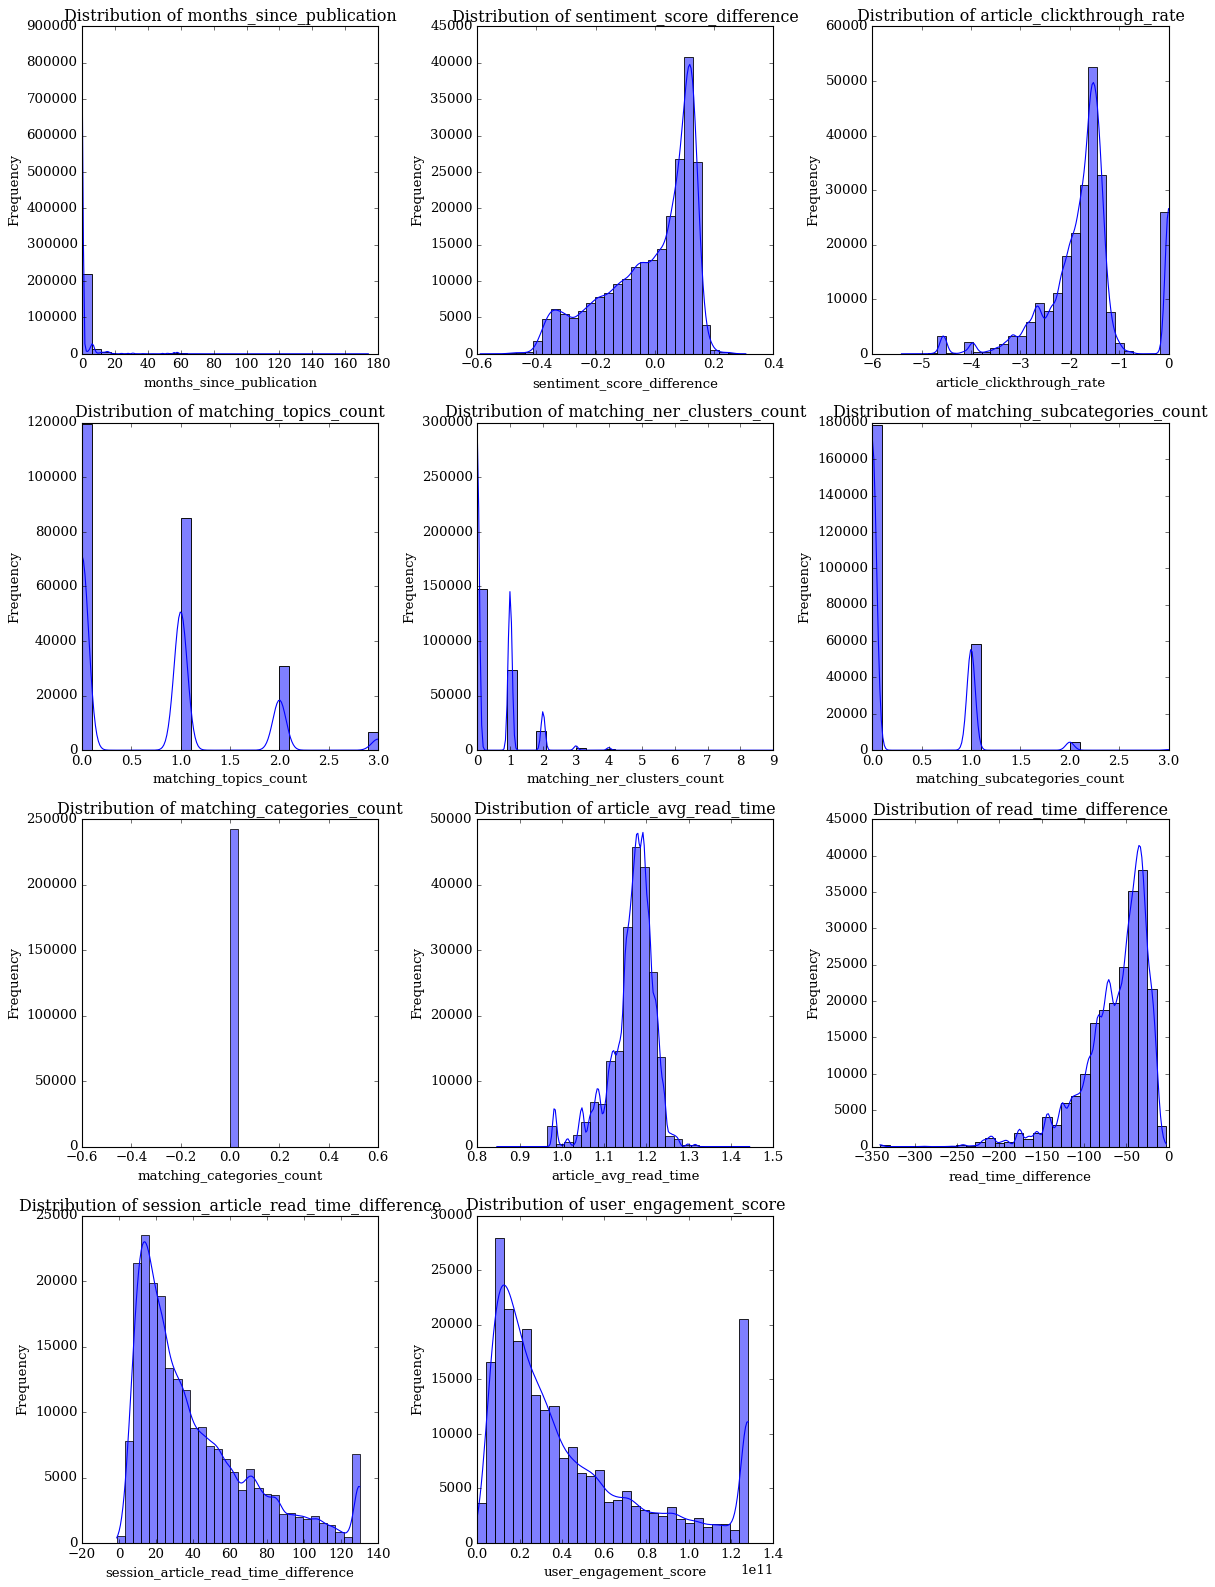

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of features to plot
features_to_plot = [
    'months_since_publication',
    'sentiment_score_difference',
    'article_clickthrough_rate',
    'matching_topics_count',
    'matching_ner_clusters_count',
    'matching_subcategories_count',
    'matching_categories_count',
    'article_avg_read_time',
    'read_time_difference',
    'session_article_read_time_difference',
    'user_engagement_score'
]

# Set up the matplotlib figure
plt.figure(figsize=(15, 20))

# Loop through each feature and create a subplot
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(4, 3, i)
    sns.histplot(data=df_final, x=feature, kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [13]:
# Feature Engineering
features = [
    'impression_read_time', 'impression_article_id_inview', 'user_id',
    'user_is_subscriber', 'impression_day_of_week_sin', 'impression_day_of_week_cos',
    'impression_hour_sin', 'impression_hour_cos', 'impression_is_frontpage',
    'session_avg_read_time', 'article_id', 'article_is_premium',
    'article_ner_clusters', 'article_topics', 'article_category', 'article_subcategory',
    'article_sentiment_score', 'article_published_year', 'article_total_inviews_log',
    'article_total_pageviews_log', 'user_top_categories', 'user_top_subcategories',
    'user_avg_sentiment_score', 'user_total_premium_viewed', 'user_avg_read_time',
    'user_top_topics', 'user_top_ner_clusters'
]
target = 'target'

# Fix Class Imbalance using RandomOverSampler
X = df_final[features]
y = df_final[target]

oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

from sklearn.ensemble import RandomForestClassifier

# Fit a Random Forest model to determine feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_resampled, y_resampled)

# Get feature importances
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Print feature importances
print("Feature importances:")
print(feature_importance_df)

ValueError: setting an array element with a sequence.

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Preprocessing for numerical and categorical features
numerical_features = X.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns.tolist()
categorical_features = X.select_dtypes(include=['bool', 'int8']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define the model with regularisation
model = LogisticRegression(solver='liblinear', class_weight='balanced', penalty='l2')

# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

# Train the model
pipeline.fit(X_train, y_train)

# Predict probabilities for the entire dataset
df_final['predicted_probability'] = pipeline.predict_proba(df_final[features])[:, 1]

# Find the article with the highest predicted probability for each impression
idx_max_prob = df_final.groupby('impression_id')['predicted_probability'].idxmax()

# Extract the predicted clicked articles
predicted_clicks = df_final.loc[idx_max_prob, ['impression_id', 'impression_article_id_inview']]

# Rename the column to match the desired output
predicted_clicks = predicted_clicks.rename(columns={'impression_article_id_inview': 'predicted_clicked_article'})

# Merge predicted clicks back to evaluate
df_final = df_final.merge(predicted_clicks, on='impression_id', how='left')

# Compare with the actual clicked article
df_final['correct_prediction'] = df_final['predicted_clicked_article'] == df_final['impression_article_id_clicked']

# Calculate accuracy
accuracy = df_final['correct_prediction'].mean()
print(f'Accuracy of highest probability prediction: {accuracy:.4f}')

# Evaluate using additional metrics
precision = precision_score(df_final['target'], df_final['correct_prediction'], zero_division=0)
recall = recall_score(df_final['target'], df_final['correct_prediction'], zero_division=0)
f1 = f1_score(df_final['target'], df_final['correct_prediction'], zero_division=0)
roc_auc = roc_auc_score(df_final['target'], df_final['predicted_probability'])

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Cross-validation
cv_scores = cross_val_score(pipeline, X_resampled, y_resampled, cv=5, scoring='roc_auc')
print(f'Cross-validated ROC AUC: {cv_scores.mean():.4f}')

Accuracy of highest probability prediction: 0.0988
Precision: 0.1217
Recall: 0.1336
F1 Score: 0.1274
ROC AUC: 0.6068
Cross-validated ROC AUC: 0.5710


In [7]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for logistic regression
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the grid search
grid_search.fit(X_resampled, y_resampled)

# Print best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best ROC AUC score:", grid_search.best_score_)

Best parameters found: {'classifier__C': 0.1, 'classifier__penalty': 'l1'}
Best ROC AUC score: 0.5711025975510913


Potential Steps to Improve the Model
	1.	Feature Engineering:
	▪	Add More Features: Consider incorporating additional features that might capture more context about the user's behaviour or the articles themselves. For instance, user interaction history, article metadata, or temporal features could be added.
	▪	Interaction Features: Create features that capture interactions between existing features, such as user preferences and article categories.
	2.	Model Complexity:
	▪	Try More Complex Models: Consider using more sophisticated models like Random Forests, Gradient Boosting Machines (e.g., XGBoost, LightGBM), or neural networks, which might capture complex patterns better.
	▪	Hyperparameter Tuning: Use grid search or random search to find the best hyperparameters for your chosen model.
	3.	Data Preprocessing:
	▪	Balance the Dataset: While you've used oversampling, ensure that the class distribution is balanced and consider using techniques like SMOTE for synthetic data generation.
	▪	Normalise Data: Ensure all features are properly scaled, especially if using models sensitive to feature scales.
	4.	Handling Class Imbalance:
	▪	Use Different Loss Functions: Consider using loss functions that are more robust to class imbalance, such as focal loss.
	▪	Class Weights: Adjust class weights in the model to give more importance to the minority class.
	5.	Evaluation and Validation:
	▪	Cross-Validation: Ensure cross-validation is performed to get a reliable estimate of model performance.
	▪	Error Analysis: Perform a detailed error analysis to understand where the model is making mistakes, which can guide feature engineering and model selection.
	6.	Ensemble Methods:
	▪	Stacking or Blending: Combine predictions from multiple models to improve performance.